# Summary

## Analysis

* Median tick-to-trade latency is ~9μs.
* Latency may spike to 20-30μs when caches aren't warm.
* Latency is likely affected by the gateway giving priority to processing all inbound socket data

## Next Steps

* Gateway should give priority to order action requests
* Feature to keep caches warm
* Review request validation (seems too expensive)
* Review OMS object caching
* Use the perf tool to investigate if interrupts can explain some latency spikes
* Re-instate cacheline prefetching

## Configuration

AMD EPYC 7443P (Zen 3) with HT disabled.


$ cat /proc/cmdline

BOOT_IMAGE=/vmlinuz-5.15.0-57-generic root=/dev/mapper/ubuntu--vg-ubuntu--lv ro isolcpus=3,4 rcu_nocbs=3,4


$ cat /etc/default/irqbalance  | grep IRQBALANCE_BANNED_CPULIST

IRQBALANCE_BANNED_CPULIST=3,4


$ sudo tuned-adm active

Current active profile: network-latency


Gateway

* --loop_cpu_affinity=3
* --loop_sleep=0ns
* --loop_timer_freq=25ns
* --enable_round_trip_latency=True


Client

* --loop_cpu_affinity=4
* --loop_sleep=0ns


CSV

journalctl --since "2023-01-09 06:00:00" -u roq-deribit | grep -e 'RTL:' -e 'GWL:' | sed 's/^.*:\([0-9,].*\)$/\1/g' | paste -d"," - -

In [1]:
import pandas as pd

In [2]:
def print_summary(df):
    stats = pd.DataFrame({
        'median': df.median(),
        'min': df.min(),
        'max': df.max(),
        '90%': df.quantile(0.9),
        '95%': df.quantile(0.95),
    })
    print(stats)
    median = df.sum(axis=1).median()
    print('total median = {}'.format(median))
    plt = df.plot(kind='bar', stacked=True)
    plt.axhline(y=median, color='black', linewidth=2, linestyle=':')

In [3]:
def print_histogram(df):
    median = df.median()
    print(median)
    plt = df.hist(bins=25, rwidth=0.75)
    plt.axvline(x=median, color='red', linewidth=2, linestyle=':')

In [4]:
def print_stats(df):
    stats = pd.DataFrame({
        'median':[df.median()],
        'min':[df.min()],
        'max':[df.max()],
        '90%':[df.quantile(0.9)],
        '95%':[df.quantile(0.9)],        
    })
    print(stats)
    plt = df.plot(kind='bar',stacked=True)
    plt.axhline(y=stats['median'][0], color='red', linewidth=2, linestyle=':')

In [5]:
df=pd.read_csv(
    'samples.csv',
    header=None,
    names=[
        'gateway','validate','buffer','fix_encode','send','clean_up',
        'round_trip_excl_gateway','md+ipc','client','ipc','server','decode','validation','rate_limiter','oms'
    ])
df

,gateway,validate,buffer,fix_encode,send,clean_up,round_trip_excl_gateway,md+ipc,client,ipc,server,decode,validation,rate_limiter,oms
0,8436,150,831,2595,4559,301,15430,2816,2240,1076,9298,1673,2625,742,5000
1,2154,30,190,612,1182,140,6493,3296,544,408,2245,551,601,211,1093
2,4268,140,241,1142,2675,70,20490,4128,1168,565,14629,11934,651,120,2044
3,3407,30,250,582,2495,50,6522,2592,1120,266,2544,480,802,211,1262
4,2365,40,381,571,1323,50,5902,2592,432,253,2625,521,621,210,1483
5,2104,50,220,571,1223,40,19578,5696,672,8130,5080,1072,1423,461,2585
6,1403,50,201,431,651,70,5401,2256,608,222,2315,331,441,130,1543
7,4549,40,431,1392,2525,161,9659,4800,1456,527,2876,321,751,301,1804
8,2665,50,231,621,1713,50,6563,2176,1056,746,2585,551,731,441,1303
9,2014,40,160,652,1112,50,5752,2624,480,323,2325,511,872,130,942


# Tick-to-Trade Latency

### Measurement
The total time from the start of processing the socket read buffer until socket send (and flush) has completed.

### Comments
The chart color encodes the various latency components for which we will provide further details.
Please note that the "server" and "gateway" categories are broken down in the following analysis.

         median   min    max     90%       95%
md+ipc   2592.0  1840   5696  4464.0   5024.00
client    672.0   320   2240  1352.0   1652.00
ipc       516.5   222   8130  1565.5   3235.50
server   2484.5  1824  14629  7189.0  10630.75
gateway  2269.5  1403   8436  4408.5   5520.75
total median = 9002.5


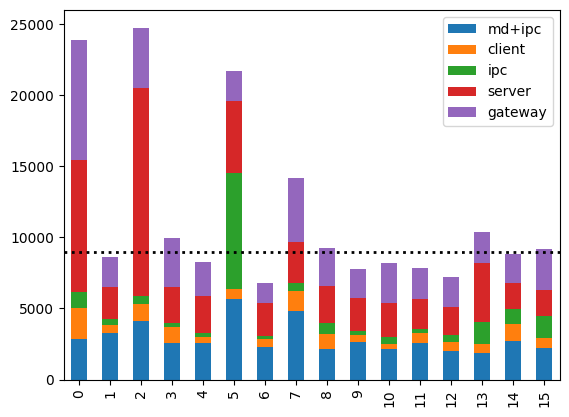

In [6]:
print_summary(df[['md+ipc','client','ipc','server','gateway']])

9002.5


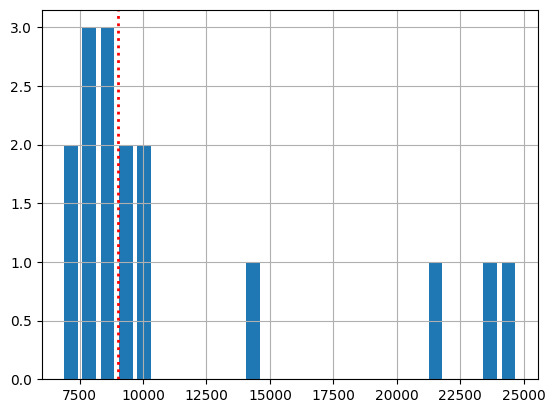

In [7]:
print_histogram(df[['round_trip_excl_gateway','gateway']].sum(axis=1))

## Socket to Client Latency

### Measurement
The time from gateway starts processing the socket read buffer until the client receives the market data update

### Comments
This seems realistics considering the decoding of FIX messages, validation, updating of internal cached order book and encoding of message for IPC.
The order book typically has >500 price levels on either side.

   median   min   max     90%     95%
0  2592.0  1840  5696  4464.0  4464.0


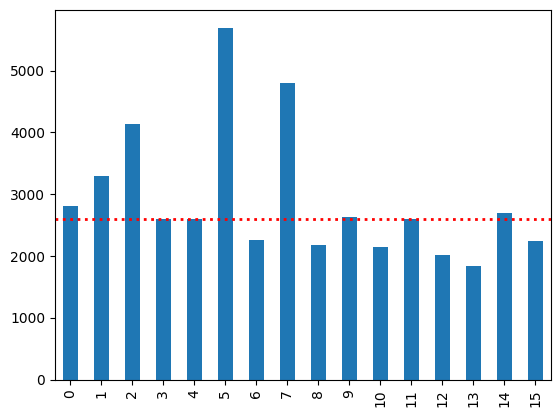

In [8]:
print_stats(df['md+ipc'])

## Client Processing Latency

### Measurement
The time from client receives the market data update until it sends an order action request

### Comments
This seems realistic considering an order book with >500 price levels on either side.
More analysis would be needed to decompose this latency.

   median  min   max     90%     95%
0   672.0  320  2240  1352.0  1352.0


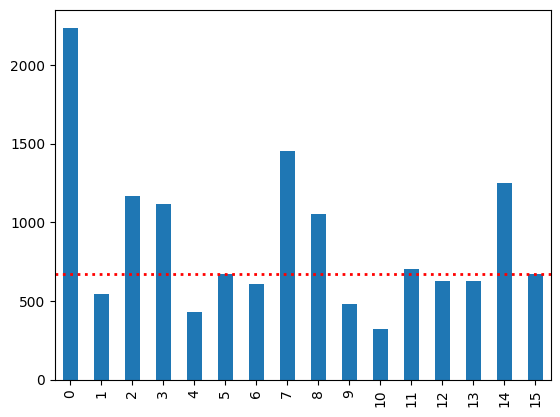

In [9]:
print_stats(df['client'])

## Client to Gateway IPC Latency

### Measurement
The time between client sends an order action request until the gateway receives it

### Comments
The values are as expected (~300ns).
The spikes can potentially be explained by the gateway being busy processing other messages.

   median  min   max     90%     95%
0   516.5  222  8130  1565.5  1565.5


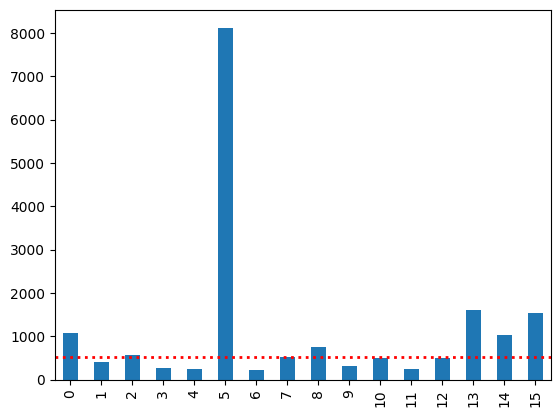

In [10]:
print_stats(df['ipc'])

## Request Decode Latency

### Measurement
The time spent on decoding the order action request

### Comments
Decoding is fast and the latency is related to cache synchronization between the cores.
Prefetching might reduce this.
The big spike is very strange, perhaps explained by an interrupt.

   median  min    max     90%     95%
0   521.0  290  11934  1372.5  1372.5


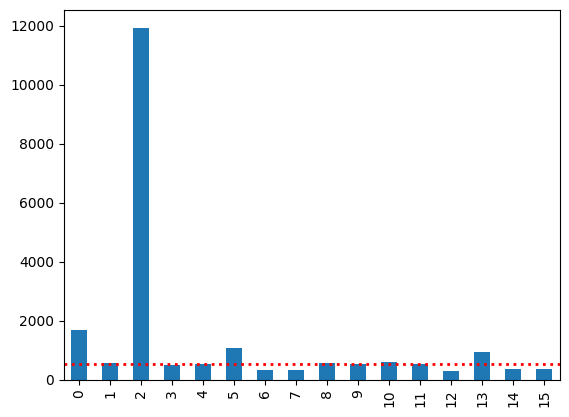

In [11]:
print_stats(df['decode'])

## Request Validation Latency

### Measurement
The time spend on validating request parameters

### Comments
This appears to be very expensive for what it does: there is a bunch of validation checks followed by the possibility of an exception being raised.
Conditions are even followed by the "unlikely" attribute.
This needs further investigation.

   median  min   max     90%     95%
0   656.5  441  2625  1233.0  1233.0


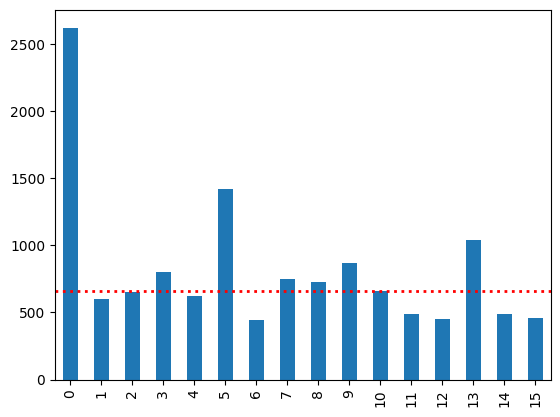

In [12]:
print_stats(df['validation'])

## OMS Latency

### Measurement
The time spent on creating order and request objects

### Comments
There is a cost with allocating the order and request objects.
The Abseil containers probably involve some initial cache warming after which we see relatively stable performance.

   median  min   max     90%     95%
0  1282.5  942  5000  2369.5  2369.5


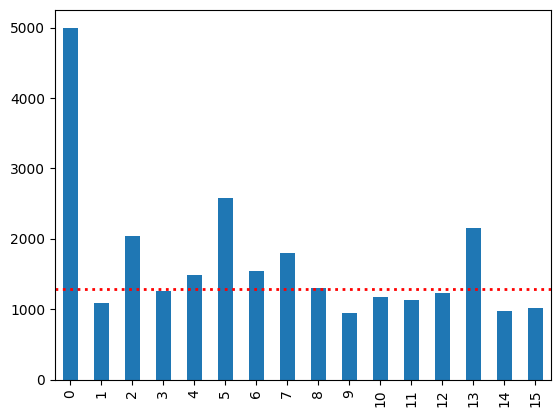

In [13]:
print_stats(df['oms'])

## FIX Encoding Latency

### Measurement
The time spent on encoding the FIX message

### Comments
This code is very optimized and appears to be stable.
Latency spikes probably relate to cache warming or interrupts.

   median  min   max     90%     95%
0   611.5  431  2595  1267.0  1267.0


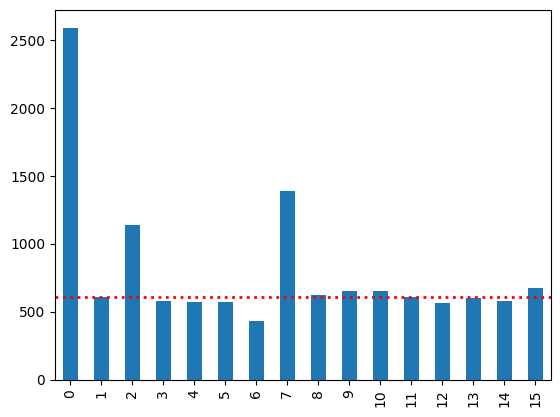

In [14]:
print_stats(df['fix_encode'])

## Socket Send Latency

### Measurement
The time spent requesting a send and flush from libevent

### Comments
Because we flush the buffer, we expect involvmeent from the kernel.
There will likely be an immediate send or, at least, a copy from our write buffer.
This latency can potentially be reduced by using kernel-bypass solutions.

   median  min   max     90%     95%
0  1313.0  651  4559  2600.0  2600.0


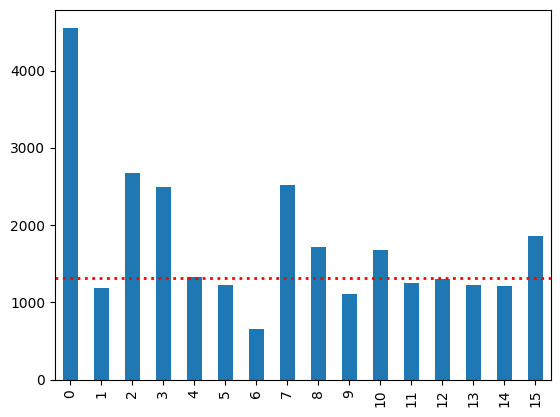

In [15]:
print_stats(df['send'])